# Example TensorFlow Data Pipeline
Jeremy Karnowski

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [57]:
import argparse
import os.path
import numpy as np
import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf

## Connecting data with models

As mentioned in this [TensorFlow How-To](https://www.tensorflow.org/how_tos/reading_data/), there are a variety of ways that you can input data into TensorFlow:
* Pre-loaded data - all of your data in a variable (con: your data has to fit in memory)
* Directly feed data into a tensor (part of your computation graph)
    * Create placeholders and feed data into this (pro: it will throw an error if you don't feed it)
* Have TensorFlow read from a file:
    * CSV files - will read each entry and injest
    * Fixed length binary files - specify the size of input and it will read it directly
    * TFRecords - a specialized binary file that contains more information about each input
    
If you are using [Amazon's Web Services](http://aws.amazon.com/) or [Google's Cloud Platform](https://cloud.google.com/) (or handling your own server architectures), then there are also opportunities to incorporate larger data pipelines with Hadoop, Spark, or Flink (open source version of Google Dataflow) which can deal with batch or streaming data at scale and supply it to a TensorFlow model.

### Specify the source of raw data and destination of TFRecords files

In [6]:
!ls ../../data

aligned
aligned.tar.gz
db
frontalFace10
frontalimages_manuallyaligned_part1.zip
frontalimages_spatiallynormalized_part1.zip
imdb_crop
imdb_crop.tar
wiki
wiki.tar
wiki_crop
wiki_crop.tar
wiki_crop_aligned_wOpenFace
wiki_crop_clean_128
wiki_crop_clean_64


In [7]:
# List the directory containing the raw data
DATA_DIR = "../../data/wiki_crop_clean_128/"
TF_DATA_DIR = "../data/"

# List out the various datasets to use
TRAIN_FILE = TF_DATA_DIR+'wiki_crop_clean_128_TRAIN.tfrecords'
#VALIDATION_FILE = 'VALIDATION.tfrecords'
TEST_FILE = TF_DATA_DIR+'wiki_crop_clean_128_TEST.tfrecords'

In [8]:
# Your data might have different formats (images of different sizes)
# In this case, you might need to know the size of the images that fit the shape of the network input
# You can use these numbers to modify the images to be cropped or padded to be properly insert into the network

IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128

### Convert raw data into TFRecords

In [15]:
# Grab all the filenames relevant to the problem at hand
# e.g. but do your own preprocessing to get proper subset
filenames = [DATA_DIR+x for x in os.listdir(DATA_DIR)]
print(len(filenames))
print(filenames[0])

25815


In [14]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecords_filename = TRAIN_FILE#"FILENAME"  # e.g. train.tfrecords, validation.tfrecords, test.tfrecords

writer = tf.python_io.TFRecordWriter(tfrecords_filename)

In [22]:
# Iterate through the files and create a record for each in tfrecords file

for img_path in filenames:
    
    # Grab data, here image data
    img = np.array(Image.open(img_path))

    # Grab relevant features, here relevant image features 
    # (esp if structure matters for type of network, e.g. convolutional)
    height = img.shape[0]
    width = img.shape[1]
    label = int(img_path[-5]) # Modify for your problem
    
    # Convert image data
    img_raw = img.tostring()
    
    # Create an example that contains all relevant info about your example
    example = tf.train.Example(features=tf.train.Features(feature={
        'height': _int64_feature(height),
        'width': _int64_feature(width),
        'image_raw': _bytes_feature(img_raw),
        'label': _int64_feature(label)}))
    
    # Write everything to the binary file
    writer.write(example.SerializeToString())

writer.close()

In [23]:
!ls

ExampleTensorFlowDataPipeline.ipynb wiki_crop_clean_128_TRAIN.tfrecords
TestTensorFlowDataPipeline.ipynb


### Convert TFRecords into data for model

#### Create method to sample from TFRecord file
When running the graph, this will produce an example and the annotation.

In [24]:
def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()
    
    _, serialized_example = reader.read(filename_queue)
    
    # Unpack the features you created in the method to save to TFRecords
    # This is for images, but the features will differ depending on your problem
    features = tf.parse_single_example(
        serialized_example,
        features={
            'height': tf.FixedLenFeature([], tf.int64),
            'width': tf.FixedLenFeature([], tf.int64),
            # 'depth': tf.FixedLenFeature([], tf.int64),      # if you encoded layers, e.g. IR cameras
            'image_raw': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([], tf.int64), 
            # Other features you encoded during encoding process
        })

    # Grab the image data that has a fixed length storage
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    
    # Get image shape to reshape it
    height = tf.cast(features['height'], tf.int32)
    width  = tf.cast(features['width'], tf.int32)
    
    ##### RESHAPE - if needed
    
    # To reshape the image as an image with 3 channels:
    # image_shape = tf.pack([height, width, 3])
    # image = tf.reshape(image, image_shape)

    # To reshape the image as a vector - here we use all three channels
    image.set_shape([IMAGE_HEIGHT*IMAGE_WIDTH*3]) # creates a vector from the images
    
    # Unclear what this is for at the moment
    # image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
    
    
    ##### TRANSFORMATIONS
    
    # If the image needs to be cropped or padded for the network
    # resized_image = tf.image.resize_image_with_crop_or_pad(image=image,
    #                                        target_height=IMAGE_HEIGHT,
    #                                        target_width=IMAGE_WIDTH)

    # My example images in TFRecords are in [0, 255] in all channels, 
    # so I transformed to [-0.5, 0.5]
    image = tf.cast(image, tf.float32) * (1. / 255) - 0.5

    # Convert label from a scalar uint8 tensor to an int32 scalar.
    label = tf.cast(features['label'], tf.int32)
    
    ##### MODIFY LABELS if needed
    
    
    return image, label

#### Create a way to grab batch of samples from TFRecord

In [25]:
def inputs(train, batch_size, num_epochs):

    if not num_epochs: num_epochs = None
        
    # For a better way to handle command line arguments
    #   
    # filename = os.path.join(FLAGS.train_dir,
    #                         TRAIN_FILE if train else VALIDATION_FILE)
    
    # Using predefined folder for data
    filename = os.path.join(TF_DATA_DIR, TRAIN_FILE if train else VALIDATION_FILE)
    
    # Creates a TF specific way to read file from folder
    filename_queue = tf.train.string_input_producer([filename], num_epochs=num_epochs)

    # Create the way to sample one example
    # Even when reading in multiple threads, share the filename queue.
    image, label = read_and_decode(filename_queue)

    # Shuffle the examples and collect them into batch_size batches.
    # The capacity and min_after_dequeue will affect memory usage depending on size
    # of your samples. Modify accordingly
    images, labels = tf.train.shuffle_batch(
        [image, label], batch_size=batch_size, num_threads=2,
        capacity=2000,
        # Ensures a minimum amount of shuffling of examples.
        min_after_dequeue=1000)

    return images, labels

### Testing out data input pipeline

In [70]:
BATCH_SIZE = 10
images_batch, labels_batch = inputs(train=True, batch_size=BATCH_SIZE, num_epochs=10)

with tf.Session() as sess:
    
    # The op for initializing the variables.
    # For some reason when using the "with tf.Session() as sess" version, 
    # this needs to be in scope. Shouldn't be the case, though. Just a warning
    init = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer()) # needed for epochs to work
    sess.run(init)
    
    # Needed for multiple threads pulling from TFRecord
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    # Actually run the TensorFlow graph that pulls out the images
    images, labels = sess.run([images_batch, labels_batch])
    
    # Check their shape - should be equivalent to batch size and shape of data
    print(images.shape)
    
    # Cease the multiple threads doing one action
    coord.request_stop()
    coord.join(threads)
    
    
    # Can do things with the data (e.g. See shape of data or visualize images)
    for i in xrange(BATCH_SIZE):
    
        # For each image, can do something
        print(images[i,:].shape)


(10, 49152)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)
(49152,)


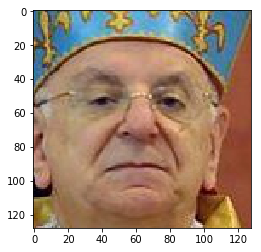

In [71]:
img = images[1].reshape(IMAGE_HEIGHT,IMAGE_WIDTH,3)
plt.imshow(img+0.5)

## Using data for models

### Create Model

In [ ]:
# Create Model

### Run training using data input and model

In [ ]:
# Create methods with TensorBoard or something else to monitor the training below

# Set up graph pieces to load data

# Set up graph pieces that use samples and labels to do prediction and get losses

# Set up graph pieces that create training procedure with specific optimizer

# Set up method that runs the whole graph set up above and logs peformance to see in TensorBoard

## References
* http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/
* https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/convert_to_records.py
* https://indico.io/blog/tensorflow-data-inputs-part1-placeholders-protobufs-queues/
* https://github.com/mnuke/tf-slim-mnist